In [3]:
# %load /Users/facai/Study/book_notes/preconfig.py
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG

逻辑回归在spark中的实现简介
=======================

分析用的代码版本信息：

```bash
~/W/g/spark ❯❯❯ git log -n 1
commit d9ad78908f6189719cec69d34557f1a750d2e6af
Author: Wenchen Fan <wenchen@databricks.com>
Date:   Fri May 26 15:01:28 2017 +0800

    [SPARK-20868][CORE] UnsafeShuffleWriter should verify the position after FileChannel.transferTo
```

### 0. 总纲

下图是ml包中逻辑回归的构成情况：

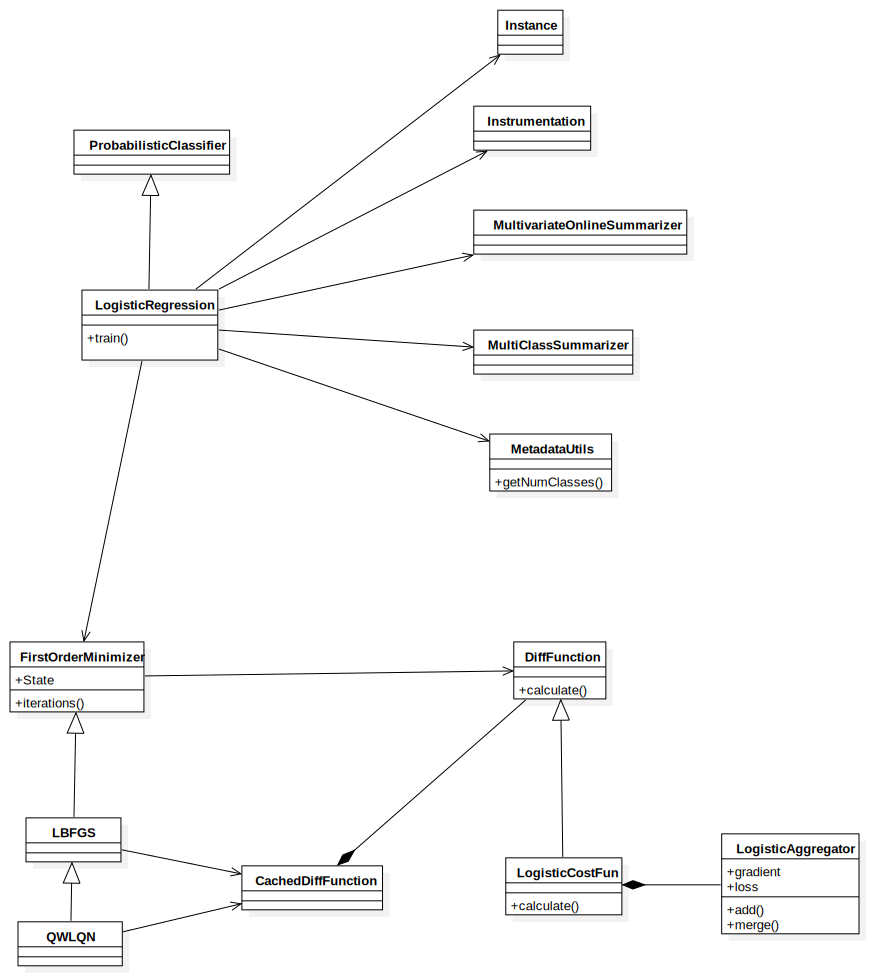

In [4]:
SVG("./res/spark_ml_lr.svg")

可以看到，逻辑回归是比较简单的，在它的`train`函数里，除开左侧的几个辅助类：

+ Instance: 封装数据
+ MetadataUtils: 数据信息
+ Instrumentation: 日志 
+ Multi*Summarizer: 统计

主要就是做两件事：

+ 构造损失函数 => costFun: DiffFunction
+ 创建寻优算子 => optimizer: FirstOrderMinizer    
  ml里两种算子都是拟牛顿法，理论上比SGD迭代更少，收敛更快。其中QWLQN是LBFGS的变种，可使用L1正则。
  
接下来，我们就将精力放在这两件事的实现上。这里寻优算子主要是根据正则确定的，而损失函数会由二分类和多分类而有所变化，下面一一叙迖述。

### 1. 寻优算子

jupyter的markdown，无法正确处理`$`取值语法，所以做了点小变动。

```scala
 645         val optimizer = if (elasticNetParam == 0.0 || regParam == 0.0) {
 646 // +--  4 lines: if (lowerBounds != null && upperBounds != null) {--------------------------------------
 650             new BreezeLBFGS[BDV[Double]](maxIter, 10, tol)
 651           }
 652         } else {
 653           val standardizationParam = standardization
 654           def regParamL1Fun = (index: Int) => {
 655 // +--  2 lines: Remove the L1 penalization on the intercept--------------------------------------------
 657             if (isIntercept) {
 658               0.0
 659             } else {
 660               if (standardizationParam) {
 661                 regParamL1
 662               } else {
 663                 val featureIndex = index / numCoefficientSets
 664 // +--  5 lines: If `standardization` is false, we still standardize the data---------------------------
 669                 if (featuresStd(featureIndex) != 0.0) {
 670                   regParamL1 / featuresStd(featureIndex)
 671                 } else {
 672                   0.0
 673                 }
 674               }
 675             }
 676           }
 677           new BreezeOWLQN[Int, BDV[Double]](maxIter, 10, regParamL1Fun, $(tol))
 678         }
```

可以看到，逻辑很简单：如果不用正则，或只用L2，就用LBFGS算子；如果用到L1正则，就用QWLQN算子。其中下半代码均是在折算合适的L1正则值。

因为QWLQN会自己处理L1正则，所以在接下来的损失函数计算中，我们只考虑L2正则，而不管L1。

### 2. 损失函数
#### 2.1 二分类

预测公式：$f(x) = \frac1{1 + e^{w^T x}}$

[损失函数](http://spark.apache.org/docs/latest/mllib-linear-methods.html#logistic-regression)定义是：

\begin{equation}
L(w;x,y) = \log(1+e^{-y w^T x}) + r_2 \cdot \frac{1}{2} w^T w + r_1 \cdot \|w\|
\end{equation}

[导数是](http://spark.apache.org/docs/latest/mllib-linear-methods.html#loss-functions)：

\begin{align}
  \frac{\partial L}{\partial w} &= -y \left(1-\frac1{1+e^{-y w^T x}} \right) \cdot x + r_2 w \pm r_1 \\
  &= \left ( \frac{y}{1+e^{-y w^T x}} - y \right ) \cdot x + r_2 w \pm r_1 \\
  \text{因为$y$只有1和-1两值，可简化为} \\
  &= \left ( \frac{1}{1+e^{-w^T x}} - y \right ) \cdot x + r_2 w \pm r_1 \\
  &= \left ( f(x) - y \right ) \cdot x + r_2 w \pm r_1
\end{align}

好，我们先看没有正则的计算，在LogisticAggregator类里：

```scala
1670   /** Update gradient and loss using binary loss function. */
1671   private def binaryUpdateInPlace(
1672       features: Vector,
1673       weight: Double,
1674       label: Double): Unit = {
1675 +--  4 lines: val localFeaturesStd = bcFeaturesStd.value----------
1679     val margin = - {
1680       var sum = 0.0
1681       features.foreachActive { (index, value) =>
1682         if (localFeaturesStd(index) != 0.0 && value != 0.0) {
1683           sum += localCoefficients(index) * value / localFeaturesStd(index)
1684         }
1685       }
1686       if (fitIntercept) sum += localCoefficients(numFeaturesPlusIntercept - 1)
1687       sum
1688     }
1689
1690     val multiplier = weight * (1.0 / (1.0 + math.exp(margin)) - label)
1691
1692     features.foreachActive { (index, value) =>
1693       if (localFeaturesStd(index) != 0.0 && value != 0.0) {
1694         localGradientArray(index) += multiplier * value / localFeaturesStd(index)
1695       }
1696     }
1697
1698     if (fitIntercept) {
1699       localGradientArray(numFeaturesPlusIntercept - 1) += multiplier
1700     }
1701
1702     if (label > 0) {
1703       // The following is equivalent to log(1 + exp(margin)) but more numerically stable.
1704       lossSum += weight * MLUtils.log1pExp(margin)
1705     } else {
1706       lossSum += weight * (MLUtils.log1pExp(margin) - margin)
1707     }
1708   }
```

其中，
+ margin = $-w^T x$    
  注意：这里用的$x / \operatorname{std}(x)$，相当于归一化，统一量纲。很奇怪，没有同时移动坐标，我不清楚是否合理。
+ multiplier = $\frac1{1 + e^{w^T x}} - y$ = $f(x) - y$
+ localGradientArray = $(f(x) - y) x$
+ lossSum = $\log(1+e^{-y w^T x})$。注意：因为margin计算时是$y=1$，所以1706L，对$y=-1$做了变换。数学技巧比较简单：

\begin{align}
  log(1 + e^x) - x &= log(1 + e^x) - log(e^x) \\
  &= log(\frac{1 + e^x}{e^x}) \\
  &= log(1 + e^{-x})
\end{align}

再在损失函数和偏导里，均加上L2的部份，代码在LogisticCostFun类的calculate方法里：

```scala
1877   override def calculate(coefficients: BDV[Double]): (Double, BDV[Double]) = {
1878 // +--  6 lines: val coeffs = Vectors.fromBreeze(coefficients)------
1884
1885     val logisticAggregator = {
1886 // +--  3 lines: val seqOp = (c: LogisticAggregator, instance: Instance) =>
1889       instances.treeAggregate(
1890         new LogisticAggregator(bcCoeffs, bcFeaturesStd, numClasses, fitIntercept,
1891           multinomial)
1892       )(seqOp, combOp, aggregationDepth)
1893     }
1894
1895     val totalGradientMatrix = logisticAggregator.gradient
1896     val coefMatrix = new DenseMatrix(numCoefficientSets, numFeaturesPlusIntercept, coeffs.toArray)
1897     // regVal is the sum of coefficients squares excluding intercept for L2 regularization.
1898     val regVal = if (regParamL2 == 0.0) {
1899       0.0
1900     } else {
1901       var sum = 0.0
1902       coefMatrix.foreachActive { case (classIndex, featureIndex, value) =>
1903         // We do not apply regularization to the intercepts
1904         val isIntercept = fitIntercept && (featureIndex == numFeatures)
1905         if (!isIntercept) {
1906 // +--  2 lines: The following code will compute the loss of the regularization; also---
1908           sum += {
1909             if (standardization) {
1910               val gradValue = totalGradientMatrix(classIndex, featureIndex)
1911               totalGradientMatrix.update(classIndex, featureIndex, gradValue + regParamL2 * value)
1912               value * value
1913 // +-- 14 lines: } else {------------------
1927             }
1928           }
1929         }
1930       }
1931       0.5 * regParamL2 * sum
1932     }
1933 // +--  2 lines: bcCoeffs.destroy(blocking = false)--------
1935     (logisticAggregator.loss + regVal, new BDV(totalGradientMatrix.toArray))
1936   }
1
```

其中，1912L和1931L是加L2正则$r_2 \cdot \frac{1}{2}w^T w$；1911L是加L2的偏导$r_2 \cdot w$。因为有额外的分支处理归一的情况，分支较多。同时，损失和偏导混在一起算，代码有点混杂。

如此，就有了二分类的损失函数和偏导数。

```scala
 601         val costFun = new LogisticCostFun(instances, numClasses, fitIntercept,
 602           standardization, bcFeaturesStd, regParamL2, multinomial = isMultinomial,
 603           aggregationDepth)
```

#### 2.2 多分类

spark在这里用的是softmax函数来代替logit函数，是比较有意思的解决方案。因为在LogisticAggregator类，已经详细地注释了推导关键过程，所以我就直接搬运过来，稍微作点附注，再把代码和公式对应起来就好。

LogisticAggregator computes the gradient and loss for binary or multinomial logistic (softmax)
loss function, as used in classification for instances in sparse or dense vector in an online
fashion.
                                                                                                  
Two LogisticAggregators can be merged together to have a summary of loss and gradient of
the corresponding joint dataset.
                                                                                                  
For improving the convergence rate during the optimization process and also to prevent against
features with very large variances exerting an overly large influence during model training,
packages like R's GLMNET perform the scaling to unit variance and remove the mean in order to
reduce the condition number. The model is then trained in this scaled space, but returns the
coefficients in the original scale. See page 9 in
http://cran.r-project.org/web/packages/glmnet/glmnet.pdf
                                                                                                  
However, we don't want to apply the [[org.apache.spark.ml.feature.StandardScaler]] on the
training dataset, and then cache the standardized dataset since it will create a lot of overhead.
As a result, we perform the scaling implicitly when we compute the objective function (though
we do not subtract the mean).
                                                                                                  
Note that there is a difference between multinomial (softmax) and binary loss. The binary case
uses one outcome class as a "pivot" and regresses the other class against the pivot. In the
multinomial case, the softmax loss function is used to model each class probability
independently. Using softmax loss produces `K` sets of coefficients, while using a pivot class
produces `K - 1` sets of coefficients (a single coefficient vector in the binary case). In the
binary case, we can say that the coefficients are shared between the positive and negative
classes. When regularization is applied, multinomial (softmax) loss will produce a result
different from binary loss since the positive and negative don't share the coefficients while the
binary regression shares the coefficients between positive and negative.
                                                                                                  
The following is a mathematical derivation for the multinomial (softmax) loss.
                                                                                                  
The probability of the multinomial outcome $y$ taking on any of the K possible outcomes is:
                                                                                                  
<blockquote>
   $$
   P(y_i=0|\vec{x}_i, \beta) = \frac{e^{\vec{x}_i^T \vec{\beta}_0}}{\sum_{k=0}^{K-1}
      e^{\vec{x}_i^T \vec{\beta}_k}} \\
   P(y_i=1|\vec{x}_i, \beta) = \frac{e^{\vec{x}_i^T \vec{\beta}_1}}{\sum_{k=0}^{K-1}
      e^{\vec{x}_i^T \vec{\beta}_k}}\\
   P(y_i=K-1|\vec{x}_i, \beta) = \frac{e^{\vec{x}_i^T \vec{\beta}_{K-1}}\,}{\sum_{k=0}^{K-1}
      e^{\vec{x}_i^T \vec{\beta}_k}}
   $$
</blockquote>
                                                                                                  
The model coefficients $\beta = (\beta_0, \beta_1, \beta_2, ..., \beta_{K-1})$ become a matrix
which has dimension of $K \times (N+1)$ if the intercepts are added. If the intercepts are not
added, the dimension will be $K \times N$.
                                                                                                  
Note that the coefficients in the model above lack identifiability. That is, any constant scalar
can be added to all of the coefficients and the probabilities remain the same.
                                                                                                  
<blockquote>
   $$
   \begin{align}
   \frac{e^{\vec{x}_i^T \left(\vec{\beta}_0 + \vec{c}\right)}}{\sum_{k=0}^{K-1}
      e^{\vec{x}_i^T \left(\vec{\beta}_k + \vec{c}\right)}}
   = \frac{e^{\vec{x}_i^T \vec{\beta}_0}e^{\vec{x}_i^T \vec{c}}\,}{e^{\vec{x}_i^T \vec{c}}
      \sum_{k=0}^{K-1} e^{\vec{x}_i^T \vec{\beta}_k}}
   = \frac{e^{\vec{x}_i^T \vec{\beta}_0}}{\sum_{k=0}^{K-1} e^{\vec{x}_i^T \vec{\beta}_k}}
   \end{align}
   $$
</blockquote>
                                                                                                  
However, when regularization is added to the loss function, the coefficients are indeed
identifiable because there is only one set of coefficients which minimizes the regularization
term. When no regularization is applied, we choose the coefficients with the minimum L2
penalty for consistency and reproducibility. For further discussion see:
                                                                                                  
Friedman, et al. "Regularization Paths for Generalized Linear Models via Coordinate Descent"
                                                                                                  
The loss of objective function for a single instance of data (we do not include the
regularization term here for simplicity) can be written as
                                                                                                  
<blockquote>
   $$
   \begin{align}
   \ell\left(\beta, x_i\right) &= -log{P\left(y_i \middle| \vec{x}_i, \beta\right)} \\
   &= log\left(\sum_{k=0}^{K-1}e^{\vec{x}_i^T \vec{\beta}_k}\right) - \vec{x}_i^T \vec{\beta}_y\\
   &= log\left(\sum_{k=0}^{K-1} e^{margins_k}\right) - margins_y
   \end{align}
   $$
</blockquote>
                                                                                                  
where ${margins}_k = \vec{x}_i^T \vec{\beta}_k$.
                                                                                                  
For optimization, we have to calculate the first derivative of the loss function, and a simple
calculation shows that
                                                                                                  
<blockquote>
   $$
   \begin{align}
   \frac{\partial \ell(\beta, \vec{x}_i, w_i)}{\partial \beta_{j, k}}
   &= x_{i,j} \cdot w_i \cdot \left(\frac{e^{\vec{x}_i \cdot \vec{\beta}_k}}{\sum_{k'=0}^{K-1}
     e^{\vec{x}_i \cdot \vec{\beta}_{k'}}\,} - I_{y=k}\right) \\
   &= x_{i, j} \cdot w_i \cdot multiplier_k
   \end{align}
   $$
</blockquote>
                                                                                                  
where $w_i$ is the sample weight, $I_{y=k}$ is an indicator function
                                                                                                  
 <blockquote>
   $$
   I_{y=k} = \begin{cases}
         1 & y = k \\
         0 & else
      \end{cases}
   $$
</blockquote>
                                                                                                  
and
                                                                                                  
<blockquote>
   $$
   multiplier_k = \left(\frac{e^{\vec{x}_i \cdot \vec{\beta}_k}}{\sum_{k=0}^{K-1}
      e^{\vec{x}_i \cdot \vec{\beta}_k}} - I_{y=k}\right)
   $$
</blockquote>

$\exp(709.78)$超出Double上限。

If any of margins is larger than 709.78, the numerical computation of multiplier and loss
function will suffer from arithmetic overflow. This issue occurs when there are outliers in
data which are far away from the hyperplane, and this will cause the failing of training once
infinity is introduced. Note that this is only a concern when max(margins) &gt; 0.
                                                                                                  
Fortunately, when max(margins) = maxMargin &gt; 0, the loss function and the multiplier can
easily be rewritten into the following equivalent numerically stable formula.
                                                                                               
这里变换非常简单，将括号打开，用指数和对数规则依次套用。                                                               
                                                                                               
<blockquote>
   $$
   \ell\left(\beta, x\right) = log\left(\sum_{k=0}^{K-1} e^{margins_k - maxMargin}\right) -
      margins_{y} + maxMargin
   $$
</blockquote>
                                                                                                  
Note that each term, $(margins_k - maxMargin)$ in the exponential is no greater than zero; as a
result, overflow will not happen with this formula.
                                                                                                  
For $multiplier$, a similar trick can be applied as the following,
                                                                                                  
<blockquote>
   $$
   multiplier_k = \left(\frac{e^{\vec{x}_i \cdot \vec{\beta}_k - maxMargin}}{\sum_{k'=0}^{K-1}
      e^{\vec{x}_i \cdot \vec{\beta}_{k'} - maxMargin}} - I_{y=k}\right)
   $$
</blockquote>

```scala
1711   private def multinomialUpdateInPlace(
1712 // +-- 12 lines: features: Vector,----------
1724     // marginOfLabel is margins(label) in the formula
1725     var marginOfLabel = 0.0
1726     var maxMargin = Double.NegativeInfinity
1727
1728     val margins = new Array[Double](numClasses)
1729     features.foreachActive { (index, value) =>
1730 // +--  2 lines: val stdValue = value / localFeaturesStd(index)-------
1732       while (j < numClasses) {
1733         margins(j) += localCoefficients(index * numClasses + j) * stdValue
1734 // +--  4 lines: j += 1-----------------
1738     while (i < numClasses) {
1739       if (fitIntercept) {
1740         margins(i) += localCoefficients(numClasses * numFeatures + i)
1741       }
1742       if (i == label.toInt) marginOfLabel = margins(i)
1743       if (margins(i) > maxMargin) {
1744         maxMargin = margins(i)
1745       }
1746       i += 1
1747     }
1748 // +--  6 lines: *---------------------
1754     val multipliers = new Array[Double](numClasses)
1755     val sum = {
1756       var temp = 0.0
1757       var i = 0
1758       while (i < numClasses) {
1759         if (maxMargin > 0) margins(i) -= maxMargin
1760         val exp = math.exp(margins(i))
1761         temp += exp
1762         multipliers(i) = exp
1763         i += 1
1764       }
1765       temp
1766     }
1767
1768     margins.indices.foreach { i =>
1769       multipliers(i) = multipliers(i) / sum - (if (label == i) 1.0 else 0.0)
1770     }
1771     features.foreachActive { (index, value) =>
1772       if (localFeaturesStd(index) != 0.0 && value != 0.0) {
1773         val stdValue = value / localFeaturesStd(index)
1774         var j = 0
1775         while (j < numClasses) {
1776           localGradientArray(index * numClasses + j) +=
1777             weight * multipliers(j) * stdValue
1778           j += 1
1779         }
1780       }
1781     }
1782     if (fitIntercept) {
1783       var i = 0
1784       while (i < numClasses) {
1785         localGradientArray(numFeatures * numClasses + i) += weight * multipliers(i)
1786         i += 1
1787       }
1788     }
1789
1790     val loss = if (maxMargin > 0) {
1791       math.log(sum) - marginOfLabel + maxMargin
1792     } else {
1793       math.log(sum) - marginOfLabel
1794     }
1795     lossSum += weight * loss
1796   }
```

+ 1728L-1733L，在计算margins = $x \beta$。1738L的循环是找出maxMargin和标签对应的marginOfLabel，因为后面公式要用到。
+ 1754L-1770L，计算了multipliers。我个人很不喜欢这种一个循环做两件事，且出口不同的风格。
+ 1771L-1788L，计算导数localGradientArray = $x_{i, j} \cdot w_i \cdot \operatorname{multiplier}_k$。
+ 1790L-1795L，根据最大margin是否大于0，计算损失值loss。注意1759L也有针对做修正。

公式较复杂，但代码挺简单的。为了效率，有的地方写得不太好看。

### 3. 小结

spark-ml里逻辑回归支持样本加权，二分类和多分类。寻优算子是相对优秀的拟牛顿算法，多分类是softmax。总体而言，功能完整够用，实现也比较优秀。但有的代码，个人认为像面条，冗余，不够清减。